##1. Download the dataset

In [3]:
#To upload file from local system
from google.colab import files
uploaded = files.upload()

Saving BTFEEDleftmenu - 100.csv to BTFEEDleftmenu - 100.csv


## 2. Import the needed 3rd party packages

In [45]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import matplotlib.dates as md
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
import time
import datetime
from datetime import datetime



In [46]:
#Reading file from local system
df = pd.read_csv("BTFEEDleftmenu - 100.csv")

In [47]:
df.head()

,response_time,event_start_ms,event_start_epoc,year,month,day
0,8.674542,564,1544956946,2018,12,16
1,8.994416,388,1544956946,2018,12,16
2,10.833192,493,1544956945,2018,12,16
3,18.026684,315,1544956945,2018,12,16
4,10.089430,32,1544956945,2018,12,16


In [48]:
# Calculating the timestamp
df ['timestamp'] = df['event_start_epoc'].apply(lambda ts: datetime.fromtimestamp(ts))
df.head()

,response_time,event_start_ms,event_start_epoc,year,month,day,timestamp
0,8.674542,564,1544956946,2018,12,16,2018-12-16 10:42:26
1,8.994416,388,1544956946,2018,12,16,2018-12-16 10:42:26
2,10.833192,493,1544956945,2018,12,16,2018-12-16 10:42:25
3,18.026684,315,1544956945,2018,12,16,2018-12-16 10:42:25
4,10.089430,32,1544956945,2018,12,16,2018-12-16 10:42:25


In [49]:
# Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [50]:
# Detecting the working days and the holydays
df['daytype'] = df['WeekDay']*2 + df['daylight']
Weekend_Night = df.loc[df['daytype'] == 0, 'month']
Weekend_Light = df.loc[df['daytype'] == 1, 'month']
Weekday_Night = df.loc[df['daytype'] == 2, 'month']
Weekday_Light = df.loc[df['daytype'] == 3, 'month']

In [51]:
df.head()

,response_time,event_start_ms,event_start_epoc,year,month,day,timestamp,hours,daylight,DayOfTheWeek,WeekDay,daytype
0,8.674542,564,1544956946,2018,12,16,2018-12-16 10:42:26,10,1,6,0,1
1,8.994416,388,1544956946,2018,12,16,2018-12-16 10:42:26,10,1,6,0,1
2,10.833192,493,1544956945,2018,12,16,2018-12-16 10:42:25,10,1,6,0,1
3,18.026684,315,1544956945,2018,12,16,2018-12-16 10:42:25,10,1,6,0,1
4,10.089430,32,1544956945,2018,12,16,2018-12-16 10:42:25,10,1,6,0,1


## 3.  Visualize the data

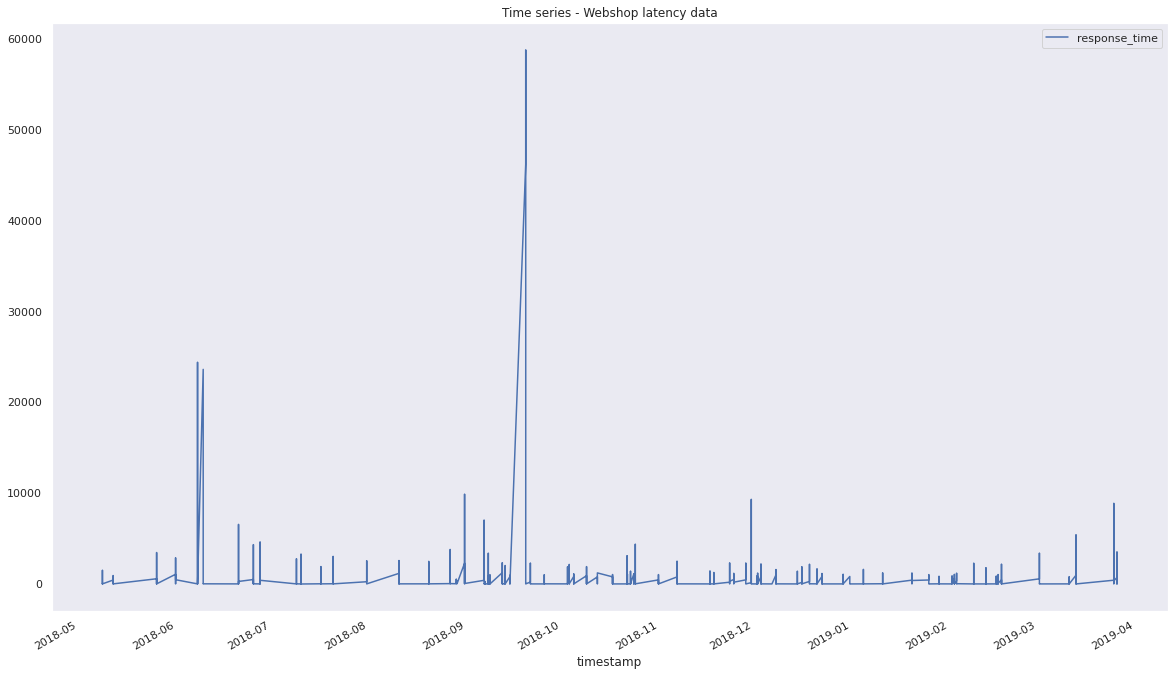

In [52]:
# plot the respond time corsponding to the timestamp
figsize=(20,12)
df.plot(x='timestamp', y='response_time', figsize=figsize, title='Time series - Webshop latency data')
plt.grid()
plt.show()

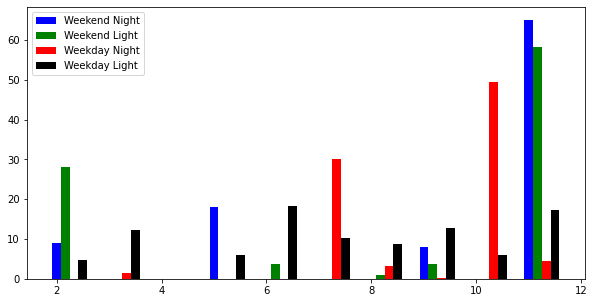

In [12]:
# Visualizing the formatted data
figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(Weekend_Night)
b_heights, b_bins = np.histogram(Weekend_Light, bins=a_bins)
c_heights, c_bins = np.histogram(Weekday_Night, bins=a_bins)
d_heights, d_bins = np.histogram(Weekday_Light, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/Weekend_Night.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/Weekend_Light.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/Weekday_Night.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/Weekday_Light.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

The above histogram shows that the Logs are comparatively more stable during Week Days in the daylights, and extremely high between October and December especially at the weekends

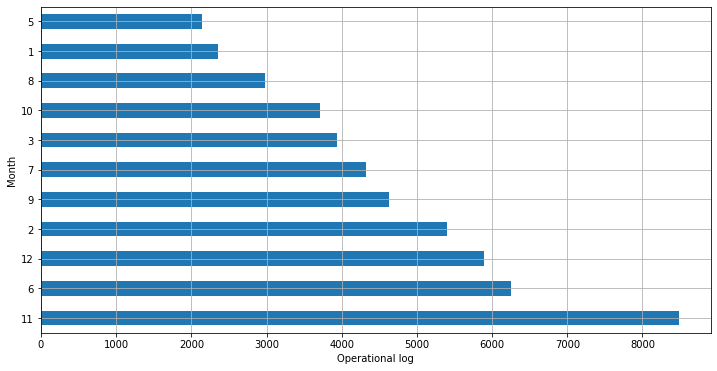

In [13]:
# Visualizing the log according to the frequency in the month
plt.figure(figsize= (12,6))
plt.ylabel('Month')
plt.xlabel('Operational log')
df['month'].value_counts().plot(kind = 'barh', grid = True)
plt.show()

## 4. Preparing the data for LSTM model

### 4.1 MinMax scaler for scaling the data

In [14]:
data_n = df[['response_time', 'event_start_ms','event_start_epoc']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n[['response_time', 'event_start_ms','event_start_epoc']])
data_n = pd.DataFrame(np_scaled)

In [15]:
data_n.head()

,0,1,2
0,-0.232311,0.215118,0.607898
1,-0.231903,-0.396415,0.607898
2,-0.229559,-0.031580,0.607898
3,-0.220386,-0.650062,0.607898
4,-0.230507,-1.633378,0.607898


### 4.2 Spliting the Dataset

we define the datasets for training and testing our neural network. To do this, we perform a simple split where we train on the first part of the dataset, which represents normal operational logs. We then test on the remaining part of the dataset that contains the anomaly logs.

In [16]:
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 8000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [17]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [18]:
#Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (41978, 50, 3)
y_train (41978,)
x_test (8000, 50, 3)
y_test (8000,)


## 5. Building the LSTM model

In [19]:
model = Sequential()

model.add(LSTM(100,input_dim=x_train.shape[-1], return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(6))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mae', optimizer='Adam')
print('compilation time : {}'.format(time.time() - start))
model.summary()

compilation time : 0.12651801109313965
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         41600     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 122,606
Trainable params: 122,606
Non-trainable params: 0
___________

### 5.1 Training the model

In [20]:
model.fit(x_train, y_train, batch_size=3028, epochs=50, validation_split=0.1)

Epoch 1/50
13/13 [==============================] - 44s 3s/step - loss: 0.3016 - val_loss: 0.2619
Epoch 2/50
13/13 [==============================] - 36s 3s/step - loss: 0.2418 - val_loss: 0.2514
Epoch 3/50
13/13 [==============================] - 37s 3s/step - loss: 0.2361 - val_loss: 0.2496
Epoch 4/50
13/13 [==============================] - 37s 3s/step - loss: 0.2301 - val_loss: 0.2482
Epoch 5/50
13/13 [==============================] - 37s 3s/step - loss: 0.2317 - val_loss: 0.2489
Epoch 6/50
13/13 [==============================] - 37s 3s/step - loss: 0.2340 - val_loss: 0.2481
Epoch 7/50
13/13 [==============================] - 37s 3s/step - loss: 0.2309 - val_loss: 0.2481
Epoch 8/50
13/13 [==============================] - 37s 3s/step - loss: 0.2335 - val_loss: 0.2479
Epoch 9/50
13/13 [==============================] - 37s 3s/step - loss: 0.2277 - val_loss: 0.2479
Epoch 10/50
13/13 [==============================] - 37s 3s/step - loss: 0.2266 - val_loss: 0.2482
Epoch 11/50
13/13 [

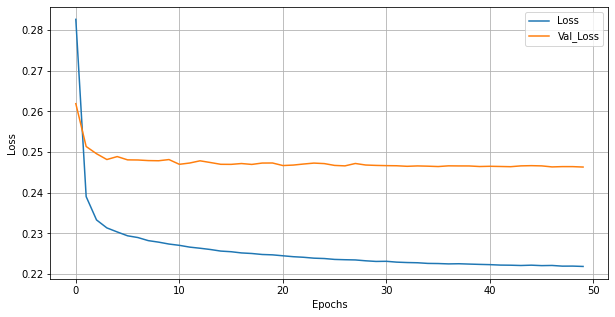

In [21]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

### 5.2 Saving the model weights into HDF5

In [22]:
# Serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


### 5.3 Difference between prediction and test data

In [23]:
# The list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
pred = loaded_model.predict(x_test)
for i in range(len(y_test)):
    pr = pred[i][0]
    ratio.append((y_test[i]/pr)-1)
    diff.append(abs(y_test[i]- pr))

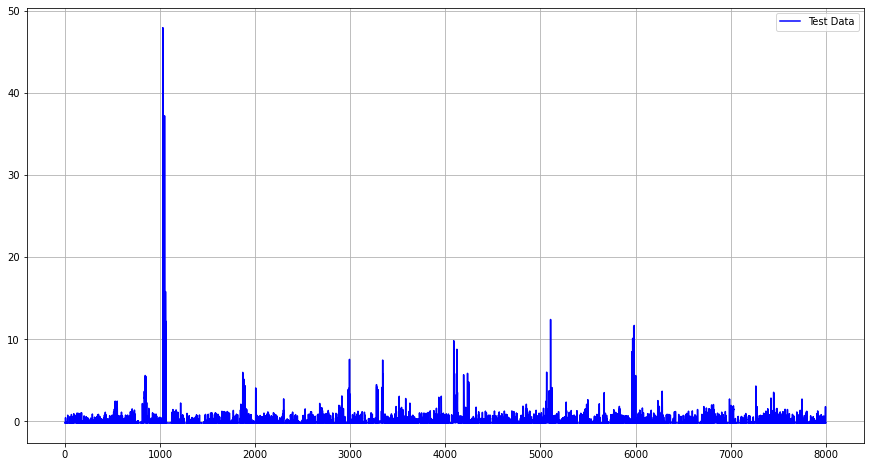

In [39]:
# Plotting the reality, Test data
plt.figure(figsize = (15, 8))
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

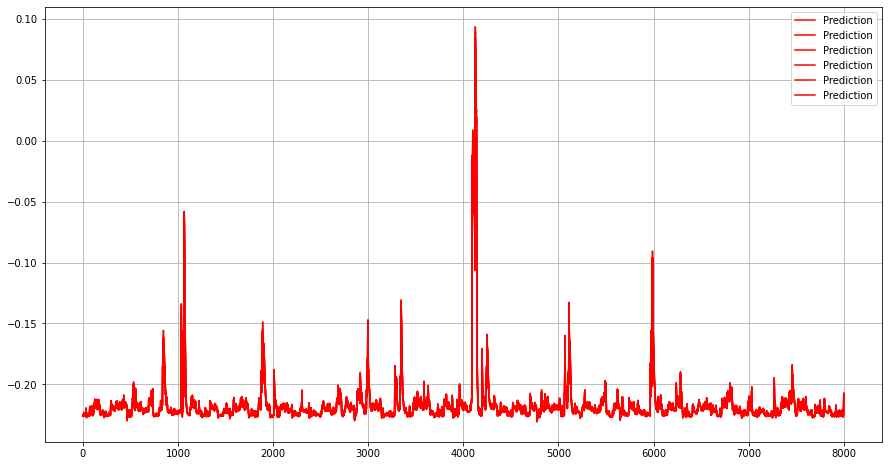

In [38]:
# Plotting the prediction and the reality
plt.figure(figsize = (15, 8))
plt.plot(pred,color='red', label='Prediction')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

## 6. Amonaly detection

In [44]:
# Anomaly estimated population
outliers_fraction = 0.01

#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly'] = complement.append(test, ignore_index='True')
print(df['anomaly'].sum())
print('threshold', threshold)

80
threshold 2.975480894423082


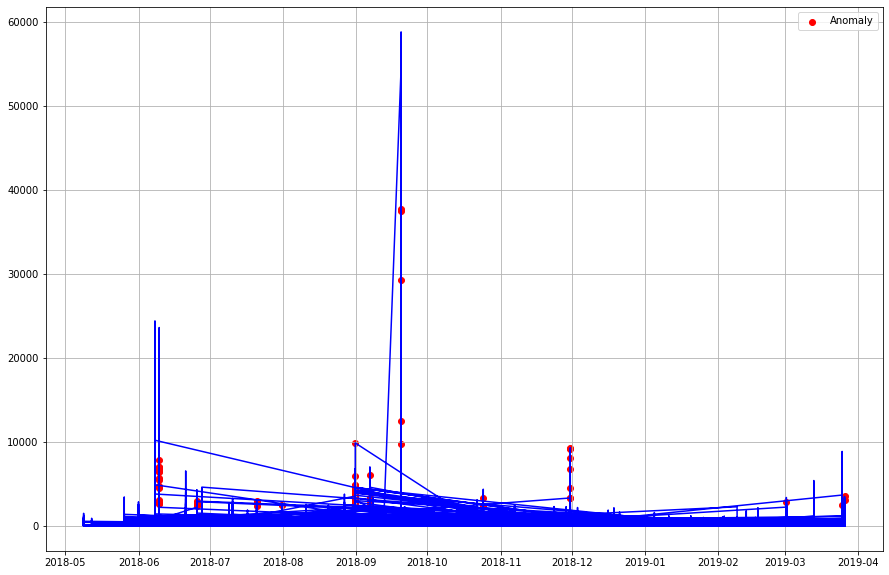

In [43]:
# Visualizing anomalies
plt.figure(figsize=(15,10))
aa = df.loc[df['anomaly'] == 1, ['timestamp', 'response_time']] #anomaly
plt.plot(df['timestamp'], df['response_time'], color='blue')
plt.scatter(aa['timestamp'],aa['response_time'], color='red', label = 'Anomaly')
plt.grid()
plt.legend()

<Figure size 1080x720 with 0 Axes>

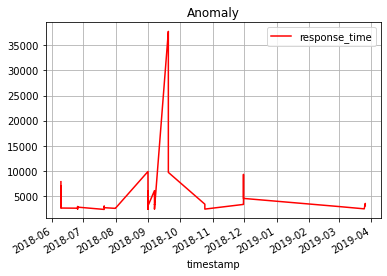

In [27]:
# Visualize the data
plt.figure(figsize=(15,10))
aa.plot(x ='timestamp',y='response_time', color='red', title = 'Anomaly')
plt.grid()
plt.legend()